# GCN, GraphSAGE and GAT

In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# pytorch geometric
from torch_geometric.nn import GCNConv # GCN
from torch_geometric.nn import SAGEConv # GraphSAGE
from torch_geometric.nn import GATConv # GAT

import torch_geometric.transforms as T

from torch_geometric.datasets import Planetoid

In [2]:
# Seed
torch.manual_seed(100)

In [3]:
# create dataframe to compile test accuracy and loss values of each model (for each dataset)

models = ['GCN', 'GraphSAGE', 'GAT']

cora_df = pd.DataFrame(models, columns = ['Model'])
cora_df['Test Loss'] = 0.0
cora_df['Test Accuracy'] = 0.0

citeseer_df = pd.DataFrame(models, columns = ['Model'])
citeseer_df['Test Loss'] = 0.0
citeseer_df['Test Accuracy'] = 0.0

## Build Models

In [4]:
# Build GCN

class GCN(nn.Module):
    def __init__(self, dataset, num_hidden, dropout):
        super(GCN, self).__init__()
        self.gc1 = GCNConv(dataset.num_features, num_hidden)
        self.gc2 = GCNConv(num_hidden, dataset.num_classes)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gc1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gc2(x, edge_index)
        x = F.log_softmax(x, dim=1)
        return x

def build_gcn_model(dataset, num_hidden=16, dropout=0.5, lr=0.01, weight_decay=5e-4):
    gcn_model = GCN(dataset, num_hidden, dropout)
    gcn_optimizer = optim.Adam(gcn_model.parameters(), lr=lr, weight_decay=weight_decay)

    return gcn_model, gcn_optimizer

In [5]:
# Build GraphSAGE (Cora)

class GraphSAGE(nn.Module):
    def __init__(self, dataset, num_hidden, dropout):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(dataset.num_node_features, num_hidden)
        self.conv2 = SAGEConv(num_hidden, dataset.num_classes)
        self.dropout = dropout
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.softmax(x, dim=1)

        return x

def build_graphsage_model(dataset, num_hidden=16, dropout=0.5, lr=0.01, weight_decay=5e-4):
    graphsage_model = GraphSAGE(dataset, num_hidden, dropout)
    graphsage_optimizer = optim.Adam(graphsage_model.parameters(), lr=lr, weight_decay=weight_decay)

    return graphsage_model, graphsage_optimizer

In [6]:
# Build GAT (Cora)

class GAT(nn.Module):
    def __init__(self, dataset, num_hidden, dropout):
        super(GAT, self).__init__()
        
        self.in_head = 8
        self.out_head = 1
        
        self.conv1 = GATConv(dataset.num_features, num_hidden, heads=self.in_head)
        self.conv2 = GATConv(num_hidden*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head)
        
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.log_softmax(x, dim=1)
        
        return x

def build_gat_model(dataset, num_hidden=16, dropout=0.5, lr=0.01, weight_decay=5e-4):
    gat_model = GAT(dataset, num_hidden, dropout)
    gat_optimizer = optim.Adam(gat_model.parameters(), lr=lr, weight_decay=weight_decay)

    return gat_model, gat_optimizer

## Cora Dataset

In [7]:
# Import Cora

cora_data = Planetoid(root = 'data/', name='Cora')

In [8]:
cora_data.transform = T.NormalizeFeatures()

In [9]:
print("Number of Classes in Cora Dataset:", cora_data.num_classes)
print("Number of Node Features in Cora Dataset:", cora_data.num_node_features)

Number of Classes in Cora Dataset: 7
Number of Node Features in Cora Dataset: 1433


In [10]:
cora = cora_data[0]
cora

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

### Graph Convolutional Network (GCN)

In [11]:
# Build GCN (Cora)

GCN_model, gcn_optimizer = build_gcn_model(cora_data, num_hidden=8, dropout=0.5, lr=0.05)
criterion = nn.CrossEntropyLoss()

In [12]:
# Train GCN Model (Cora)

train_loss_arr = []
train_acc_arr = []
val_loss_arr = []
val_acc_arr = []

GCN_model.train()

for epoch in range(100):
    out = GCN_model(cora)
    loss = criterion(out[cora.train_mask], cora.y[cora.train_mask])
    gcn_optimizer.zero_grad()
    loss.backward()
    gcn_optimizer.step()

    _, pred = torch.max(out[cora.train_mask], dim=1)
    correct = (pred == cora.y[cora.train_mask]).sum().item()
    acc = correct/cora.train_mask.sum().item()
    
    train_loss_arr.append(loss.item())
    train_acc_arr.append(acc)
    
    if epoch%5 == 0:
        print('Epoch {:03d}:'.format(epoch))
        print('train_loss: {:.4f} train_acc: {:.4f}'.format(loss.item(), acc))
        
    GCN_model.eval()
    out = GCN_model(cora)
    loss = criterion(out[cora.test_mask], cora.y[cora.test_mask])
    _, pred = torch.max(out[cora.test_mask], dim=1)
    correct = (pred == cora.y[cora.test_mask]).sum().item()
    acc = correct/cora.test_mask.sum().item()
    
    val_loss_arr.append(loss.item())
    val_acc_arr.append(acc)
    
    if epoch%5 == 0:
        print("val_loss: {:.4f} val_acc: {:.4f}".format(loss.item(), acc))
        print()
        
print("Model Trained")

Epoch 000:
train_loss: 1.9455 train_acc: 0.1429
val_loss: 1.9347 val_acc: 0.1310

Epoch 005:
train_loss: 1.8551 train_acc: 0.5571
val_loss: 1.8595 val_acc: 0.4750

Epoch 010:
train_loss: 1.6929 train_acc: 0.6000
val_loss: 1.7554 val_acc: 0.5720

Epoch 015:
train_loss: 1.4918 train_acc: 0.8214
val_loss: 1.6155 val_acc: 0.6780

Epoch 020:
train_loss: 1.2818 train_acc: 0.8214
val_loss: 1.4930 val_acc: 0.6600

Epoch 025:
train_loss: 1.0733 train_acc: 0.9000
val_loss: 1.3750 val_acc: 0.6780

Epoch 030:
train_loss: 0.8811 train_acc: 0.9571
val_loss: 1.2600 val_acc: 0.7040

Epoch 035:
train_loss: 0.7212 train_acc: 0.9714
val_loss: 1.1552 val_acc: 0.7360

Epoch 040:
train_loss: 0.5993 train_acc: 0.9857
val_loss: 1.0792 val_acc: 0.7480

Epoch 045:
train_loss: 0.5071 train_acc: 0.9857
val_loss: 1.0162 val_acc: 0.7510

Epoch 050:
train_loss: 0.4391 train_acc: 0.9929
val_loss: 0.9811 val_acc: 0.7450

Epoch 055:
train_loss: 0.3888 train_acc: 1.0000
val_loss: 0.9457 val_acc: 0.7500

Epoch 060:
train

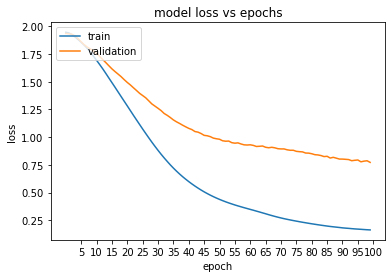

In [13]:
# Evaluate GCN Model (Cora)

plt.figure(1)
plt.plot(train_loss_arr)
plt.plot(val_loss_arr)
plt.title('model loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.legend(['train', 'validation'], loc='upper left')

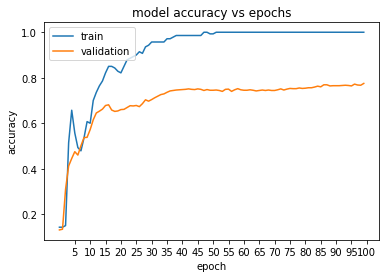

In [14]:
plt.figure(1)
plt.plot(train_acc_arr)
plt.plot(val_acc_arr)
plt.title('model accuracy vs epochs')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.legend(['train', 'validation'], loc='upper left')

In [15]:
print("test_loss: {:.4f} test_acc: {:.4f}".format(loss.item(), acc))

test_loss: 0.7726 test_acc: 0.7750


In [16]:
# add test loss and accuracy values to table

cora_df['Test Loss'][0] = loss.item()
cora_df['Test Accuracy'][0] = acc

/var/folders/1f/gg6wtk9n3yj9dh3mbt8dfd000000gn/T/ipykernel_5949/4106376664.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cora_df['Test Loss'][0] = loss.item()
/var/folders/1f/gg6wtk9n3yj9dh3mbt8dfd000000gn/T/ipykernel_5949/4106376664.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cora_df['Test Accuracy'][0] = acc


### GraphSAGE

In [17]:
# Build GraphSAGE (Cora)

GraphSAGE_model, graphsage_optimizer = build_graphsage_model(cora_data, num_hidden=8, dropout=0.5, lr=0.05)
criterion = nn.CrossEntropyLoss()

In [18]:
# Train GraphSAGE Model (Cora)

train_loss_arr = []
train_acc_arr = []
val_loss_arr = []
val_acc_arr = []

GraphSAGE_model.train()

for epoch in range(100):
    out = GraphSAGE_model(cora)
    loss = criterion(out[cora.train_mask], cora.y[cora.train_mask])
    graphsage_optimizer.zero_grad()
    loss.backward()
    graphsage_optimizer.step()

    _, pred = torch.max(out[cora.train_mask], dim=1)
    correct = (pred == cora.y[cora.train_mask]).sum().item()
    acc = correct/cora.train_mask.sum().item()
    
    train_loss_arr.append(loss.item())
    train_acc_arr.append(acc)
    
    if epoch%5 == 0:
        print('Epoch {:03d}:'.format(epoch))
        print('train_loss: {:.4f} train_acc: {:.4f}'.format(loss.item(), acc))
    
    GraphSAGE_model.eval()
    out = GraphSAGE_model(cora)
    loss = criterion(out[cora.test_mask], cora.y[cora.test_mask])
    _, pred = torch.max(out[cora.test_mask], dim=1)
    correct = (pred == cora.y[cora.test_mask]).sum().item()
    acc = correct/cora.test_mask.sum().item()
    
    val_loss_arr.append(loss.item())
    val_acc_arr.append(acc)
    
    if epoch%5 == 0:
        print("val_loss: {:.4f} val_acc: {:.4f}".format(loss.item(), acc))
        print()
    
print("Model Trained")

Epoch 000:
train_loss: 1.9462 train_acc: 0.1429
val_loss: 1.9365 val_acc: 0.3190

Epoch 005:
train_loss: 1.9099 train_acc: 0.5286
val_loss: 1.9249 val_acc: 0.2360

Epoch 010:
train_loss: 1.7816 train_acc: 0.6857
val_loss: 1.8674 val_acc: 0.3950

Epoch 015:
train_loss: 1.5558 train_acc: 0.8857
val_loss: 1.7158 val_acc: 0.6860

Epoch 020:
train_loss: 1.3747 train_acc: 0.9643
val_loss: 1.6130 val_acc: 0.7740

Epoch 025:
train_loss: 1.2863 train_acc: 0.9929
val_loss: 1.5553 val_acc: 0.7740

Epoch 030:
train_loss: 1.2552 train_acc: 1.0000
val_loss: 1.5308 val_acc: 0.7800

Epoch 035:
train_loss: 1.2386 train_acc: 1.0000
val_loss: 1.5164 val_acc: 0.7890

Epoch 040:
train_loss: 1.2283 train_acc: 1.0000
val_loss: 1.5100 val_acc: 0.7890

Epoch 045:
train_loss: 1.2216 train_acc: 1.0000
val_loss: 1.5057 val_acc: 0.7920

Epoch 050:
train_loss: 1.2174 train_acc: 1.0000
val_loss: 1.5032 val_acc: 0.7940

Epoch 055:
train_loss: 1.2143 train_acc: 1.0000
val_loss: 1.5011 val_acc: 0.7940

Epoch 060:
train

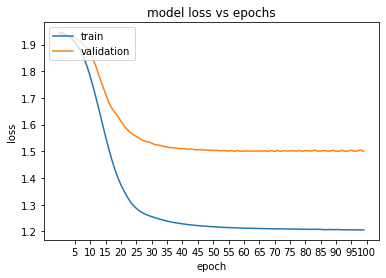

In [19]:
# Evaluate GraphSAGE Model (Cora)

plt.figure(1)
plt.plot(train_loss_arr)
plt.plot(val_loss_arr)
plt.title('model loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.legend(['train', 'validation'], loc='upper left')

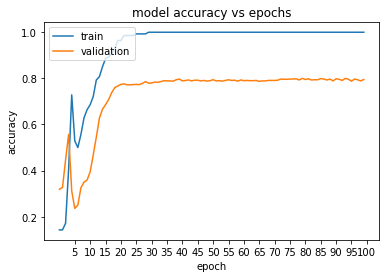

In [20]:
plt.figure(1)
plt.plot(train_acc_arr)
plt.plot(val_acc_arr)
plt.title('model accuracy vs epochs')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.legend(['train', 'validation'], loc='upper left')

In [21]:
print("test_loss: {:.4f} test_acc: {:.4f}".format(loss.item(), acc))

test_loss: 1.4999 test_acc: 0.7950


In [22]:
# add test loss and accuracy values to table

cora_df['Test Loss'][1] = loss.item()
cora_df['Test Accuracy'][1] = acc

/var/folders/1f/gg6wtk9n3yj9dh3mbt8dfd000000gn/T/ipykernel_5949/4184785398.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cora_df['Test Loss'][1] = loss.item()
/var/folders/1f/gg6wtk9n3yj9dh3mbt8dfd000000gn/T/ipykernel_5949/4184785398.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cora_df['Test Accuracy'][1] = acc


### Graph Attention Network (GAT)

In [23]:
# Build GAT (Cora)

GAT_model, gat_optimizer = build_graphsage_model(cora_data, num_hidden=8, dropout=0.5, lr=0.05)
criterion = nn.CrossEntropyLoss()

In [24]:
# Train GAT Model (Cora)

train_loss_arr = []
train_acc_arr = []
val_loss_arr = []
val_acc_arr = []

GAT_model.train()

# epochs
for epoch in range(100):
    out = GAT_model(cora)
    loss = criterion(out[cora.train_mask], cora.y[cora.train_mask])
    gat_optimizer.zero_grad()
    loss.backward()
    gat_optimizer.step()
    
    _, pred = torch.max(out[cora.train_mask], dim=1)
    correct = (pred == cora.y[cora.train_mask]).sum().item()
    acc = correct/cora.train_mask.sum().item()
    
    train_loss_arr.append(loss.item())
    train_acc_arr.append(acc)
    
    if epoch%5 == 0:
        print('Epoch {:03d}:'.format(epoch))
        print('train_loss: {:.4f} train_acc: {:.4f}'.format(loss.item(), acc))
        
    GAT_model.eval()
    out = GAT_model(cora)
    loss = criterion(out[cora.test_mask], cora.y[cora.test_mask])
    _, pred = torch.max(out[cora.test_mask], dim=1)
    correct = (pred == cora.y[cora.test_mask]).sum().item()
    acc = correct / cora.test_mask.sum().item()
    
    val_loss_arr.append(loss.item())
    val_acc_arr.append(acc)
    
    if epoch%5 == 0:
        print("val_loss: {:.4f} val_acc: {:.4f}".format(loss.item(), acc))
        print()
        
print("Model Trained")

Epoch 000:
train_loss: 1.9464 train_acc: 0.1429
val_loss: 1.9442 val_acc: 0.1300

Epoch 005:
train_loss: 1.9046 train_acc: 0.4214
val_loss: 1.9264 val_acc: 0.3300

Epoch 010:
train_loss: 1.7608 train_acc: 0.5571
val_loss: 1.8505 val_acc: 0.4460

Epoch 015:
train_loss: 1.5767 train_acc: 0.7571
val_loss: 1.7729 val_acc: 0.5290

Epoch 020:
train_loss: 1.4350 train_acc: 0.8643
val_loss: 1.7195 val_acc: 0.5640

Epoch 025:
train_loss: 1.3649 train_acc: 0.8643
val_loss: 1.6761 val_acc: 0.5590

Epoch 030:
train_loss: 1.2960 train_acc: 1.0000
val_loss: 1.5796 val_acc: 0.7450

Epoch 035:
train_loss: 1.2382 train_acc: 1.0000
val_loss: 1.5444 val_acc: 0.7640

Epoch 040:
train_loss: 1.2318 train_acc: 1.0000
val_loss: 1.5283 val_acc: 0.7660

Epoch 045:
train_loss: 1.2208 train_acc: 1.0000
val_loss: 1.5128 val_acc: 0.7740

Epoch 050:
train_loss: 1.2162 train_acc: 1.0000
val_loss: 1.5081 val_acc: 0.7760

Epoch 055:
train_loss: 1.2126 train_acc: 1.0000
val_loss: 1.5076 val_acc: 0.7760

Epoch 060:
train

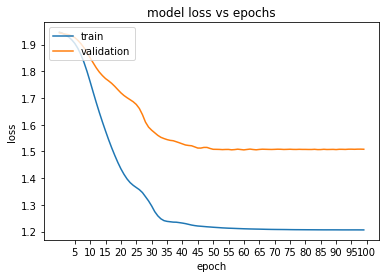

In [25]:
# Evaluate GAT Model (Cora)

plt.figure(1)
plt.plot(train_loss_arr)
plt.plot(val_loss_arr)
plt.title('model loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.legend(['train', 'validation'], loc='upper left')

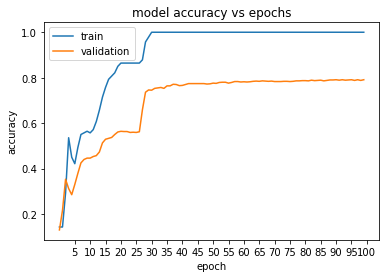

In [26]:
plt.figure(1)
plt.plot(train_acc_arr)
plt.plot(val_acc_arr)
plt.title('model accuracy vs epochs')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.legend(['train', 'validation'], loc='upper left')

In [27]:
print("test_loss: {:.4f} test_acc: {:.4f}".format(loss.item(), acc))

test_loss: 1.5083 test_acc: 0.7910


In [28]:
# add test loss and accuracy values to table

cora_df['Test Loss'][2] = loss.item()
cora_df['Test Accuracy'][2] = acc

/var/folders/1f/gg6wtk9n3yj9dh3mbt8dfd000000gn/T/ipykernel_5949/236544870.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cora_df['Test Loss'][2] = loss.item()
/var/folders/1f/gg6wtk9n3yj9dh3mbt8dfd000000gn/T/ipykernel_5949/236544870.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cora_df['Test Accuracy'][2] = acc


In [29]:
print(cora_df)

       Model  Test Loss  Test Accuracy
0        GCN   0.772594          0.775
1  GraphSAGE   1.499864          0.795
2        GAT   1.508257          0.791


## CiteSeer Dataset

In [30]:
# Import CiteSeer

citeseer_data = Planetoid(root = 'data/', name='CiteSeer')

In [31]:
citeseer_data.transform = T.NormalizeFeatures()

In [32]:
print("Number of Classes in CiteSeer Dataset:", citeseer_data.num_classes)
print("Number of Node Features in CiteSeer Dataset:", citeseer_data.num_node_features)

Number of Classes in CiteSeer Dataset: 6
Number of Node Features in CiteSeer Dataset: 3703


In [33]:
citeseer = citeseer_data[0]
citeseer

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

### Graph Convolutional Network (GCN)

In [34]:
# Build GCN (CiteSeer)

GCN_model, gcn_optimizer = build_gcn_model(citeseer_data, num_hidden=8, dropout=0.5, lr=0.05)
criterion = nn.CrossEntropyLoss()

In [35]:
# Train GCN Model (CiteSeer)

train_loss_arr = []
train_acc_arr = []
val_loss_arr = []
val_acc_arr = []

GCN_model.train()

for epoch in range(100):
    out = GCN_model(citeseer)
    loss = criterion(out[citeseer.train_mask], citeseer.y[citeseer.train_mask])
    gcn_optimizer.zero_grad()
    loss.backward()
    gcn_optimizer.step()

    _, pred = torch.max(out[citeseer.train_mask], dim=1)
    correct = (pred == citeseer.y[citeseer.train_mask]).sum().item()
    acc = correct/citeseer.train_mask.sum().item()
    
    train_loss_arr.append(loss.item())
    train_acc_arr.append(acc)
    
    if epoch%5 == 0:
        print('Epoch {:03d}:'.format(epoch))
        print('train_loss: {:.4f} train_acc: {:.4f}'.format(loss.item(), acc))
        
    GCN_model.eval()
    out = GCN_model(citeseer)
    loss = criterion(out[citeseer.test_mask], citeseer.y[citeseer.test_mask])
    _, pred = torch.max(out[citeseer.test_mask], dim=1)
    correct = (pred == citeseer.y[citeseer.test_mask]).sum().item()
    acc = correct/citeseer.test_mask.sum().item()
    
    val_loss_arr.append(loss.item())
    val_acc_arr.append(acc)
    
    if epoch%5 == 0:
        print("val_loss: {:.4f} val_acc: {:.4f}".format(loss.item(), acc))
        print()
        
print("Model Trained")

Epoch 000:
train_loss: 1.7917 train_acc: 0.1583
val_loss: 1.7846 val_acc: 0.1690

Epoch 005:
train_loss: 1.7055 train_acc: 0.6250
val_loss: 1.7490 val_acc: 0.3120

Epoch 010:
train_loss: 1.5563 train_acc: 0.6583
val_loss: 1.6760 val_acc: 0.4820

Epoch 015:
train_loss: 1.3605 train_acc: 0.7417
val_loss: 1.5843 val_acc: 0.5190

Epoch 020:
train_loss: 1.1578 train_acc: 0.7917
val_loss: 1.4801 val_acc: 0.5620

Epoch 025:
train_loss: 0.9841 train_acc: 0.8250
val_loss: 1.3877 val_acc: 0.6060

Epoch 030:
train_loss: 0.8506 train_acc: 0.8583
val_loss: 1.3057 val_acc: 0.6180

Epoch 035:
train_loss: 0.7496 train_acc: 0.8833
val_loss: 1.2444 val_acc: 0.6550

Epoch 040:
train_loss: 0.6734 train_acc: 0.9083
val_loss: 1.1921 val_acc: 0.6580

Epoch 045:
train_loss: 0.6137 train_acc: 0.9000
val_loss: 1.1622 val_acc: 0.6610

Epoch 050:
train_loss: 0.5594 train_acc: 0.9250
val_loss: 1.1216 val_acc: 0.6720

Epoch 055:
train_loss: 0.5080 train_acc: 0.9667
val_loss: 1.1008 val_acc: 0.6790

Epoch 060:
train

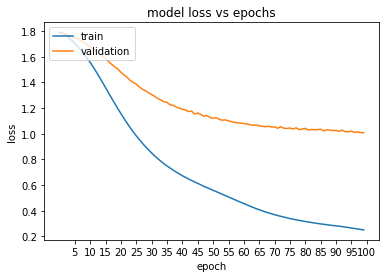

In [36]:
# Evaluate GCN Model (CiteSeer)

plt.figure(1)
plt.plot(train_loss_arr)
plt.plot(val_loss_arr)
plt.title('model loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.legend(['train', 'validation'], loc='upper left')

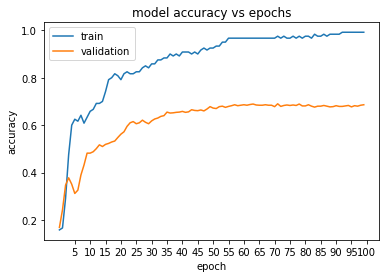

In [37]:
plt.figure(1)
plt.plot(train_acc_arr)
plt.plot(val_acc_arr)
plt.title('model accuracy vs epochs')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.legend(['train', 'validation'], loc='upper left')

In [38]:
print("test_loss: {:.4f} test_acc: {:.4f}".format(loss.item(), acc))

test_loss: 1.0076 test_acc: 0.6860


In [39]:
# add test loss and accuracy values to table

citeseer_df['Test Loss'][0] = loss.item()
citeseer_df['Test Accuracy'][0] = acc

/var/folders/1f/gg6wtk9n3yj9dh3mbt8dfd000000gn/T/ipykernel_5949/368259315.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citeseer_df['Test Loss'][0] = loss.item()
/var/folders/1f/gg6wtk9n3yj9dh3mbt8dfd000000gn/T/ipykernel_5949/368259315.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citeseer_df['Test Accuracy'][0] = acc


### GraphSAGE

In [40]:
# Build GraphSAGE (CiteSeer)

GraphSAGE_model, graphsage_optimizer = build_graphsage_model(citeseer_data, num_hidden=8, dropout=0.5, lr=0.05)
criterion = nn.CrossEntropyLoss()

In [41]:
# Train GraphSAGE Model (CiteSeer)

train_loss_arr = []
train_acc_arr = []
val_loss_arr = []
val_acc_arr = []

GraphSAGE_model.train()

for epoch in range(100):
    out = GraphSAGE_model(citeseer)
    loss = criterion(out[citeseer.train_mask], citeseer.y[citeseer.train_mask])
    graphsage_optimizer.zero_grad()
    loss.backward()
    graphsage_optimizer.step()

    _, pred = torch.max(out[citeseer.train_mask], dim=1)
    correct = (pred == citeseer.y[citeseer.train_mask]).sum().item()
    acc = correct/citeseer.train_mask.sum().item()
    
    train_loss_arr.append(loss.item())
    train_acc_arr.append(acc)
    
    if epoch%5 == 0:
        print('Epoch {:03d}:'.format(epoch))
        print('train_loss: {:.4f} train_acc: {:.4f}'.format(loss.item(), acc))
    
    GraphSAGE_model.eval()
    out = GraphSAGE_model(citeseer)
    loss = criterion(out[citeseer.test_mask], citeseer.y[citeseer.test_mask])
    _, pred = torch.max(out[citeseer.test_mask], dim=1)
    correct = (pred == citeseer.y[citeseer.test_mask]).sum().item()
    acc = correct/citeseer.test_mask.sum().item()
    
    val_loss_arr.append(loss.item())
    val_acc_arr.append(acc)
    
    if epoch%5 == 0:
        print("val_loss: {:.4f} val_acc: {:.4f}".format(loss.item(), acc))
        print()
    
print("Model Trained")

Epoch 000:
train_loss: 1.7920 train_acc: 0.1667
val_loss: 1.7918 val_acc: 0.1820

Epoch 005:
train_loss: 1.7732 train_acc: 0.3417
val_loss: 1.7852 val_acc: 0.2240

Epoch 010:
train_loss: 1.6971 train_acc: 0.4667
val_loss: 1.7491 val_acc: 0.2980

Epoch 015:
train_loss: 1.5204 train_acc: 0.8417
val_loss: 1.6803 val_acc: 0.5130

Epoch 020:
train_loss: 1.3382 train_acc: 0.9583
val_loss: 1.5968 val_acc: 0.6790

Epoch 025:
train_loss: 1.2208 train_acc: 1.0000
val_loss: 1.5509 val_acc: 0.6960

Epoch 030:
train_loss: 1.1645 train_acc: 1.0000
val_loss: 1.5202 val_acc: 0.6990

Epoch 035:
train_loss: 1.1391 train_acc: 1.0000
val_loss: 1.5067 val_acc: 0.6950

Epoch 040:
train_loss: 1.1228 train_acc: 1.0000
val_loss: 1.5001 val_acc: 0.6930

Epoch 045:
train_loss: 1.1137 train_acc: 1.0000
val_loss: 1.4943 val_acc: 0.6920

Epoch 050:
train_loss: 1.1069 train_acc: 1.0000
val_loss: 1.4901 val_acc: 0.6920

Epoch 055:
train_loss: 1.1024 train_acc: 1.0000
val_loss: 1.4897 val_acc: 0.6890

Epoch 060:
train

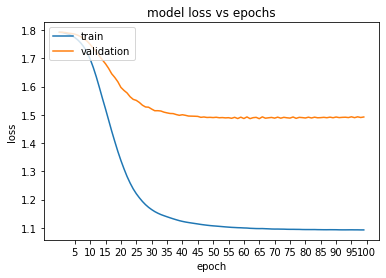

In [42]:
# Evaluate GraphSAGE Model (CiteSeer)

plt.figure(1)
plt.plot(train_loss_arr)
plt.plot(val_loss_arr)
plt.title('model loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.legend(['train', 'validation'], loc='upper left')

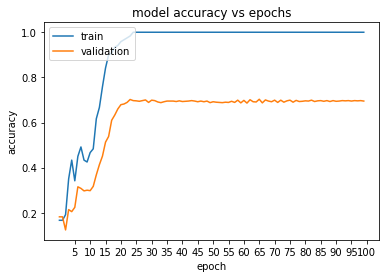

In [43]:
plt.figure(1)
plt.plot(train_acc_arr)
plt.plot(val_acc_arr)
plt.title('model accuracy vs epochs')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.legend(['train', 'validation'], loc='upper left')

In [44]:
print("test_loss: {:.4f} test_acc: {:.4f}".format(loss.item(), acc))

test_loss: 1.4921 test_acc: 0.6950


In [45]:
# add test loss and accuracy values to table

citeseer_df['Test Loss'][1] = loss.item()
citeseer_df['Test Accuracy'][1] = acc

/var/folders/1f/gg6wtk9n3yj9dh3mbt8dfd000000gn/T/ipykernel_5949/1529784203.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citeseer_df['Test Loss'][1] = loss.item()
/var/folders/1f/gg6wtk9n3yj9dh3mbt8dfd000000gn/T/ipykernel_5949/1529784203.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citeseer_df['Test Accuracy'][1] = acc


### Graph Attention Network (GAT)

In [46]:
# Build GAT (CiteSeer)

GAT_model, gat_optimizer = build_graphsage_model(citeseer_data, num_hidden=8, dropout=0.5, lr=0.05)
criterion = nn.CrossEntropyLoss()

In [47]:
# Train GAT Model (CiteSeer)

train_loss_arr = []
train_acc_arr = []
val_loss_arr = []
val_acc_arr = []

GAT_model.train()

# epochs
for epoch in range(100):
    out = GAT_model(citeseer)
    loss = criterion(out[citeseer.train_mask], citeseer.y[citeseer.train_mask])
    gat_optimizer.zero_grad()
    loss.backward()
    gat_optimizer.step()
    
    _, pred = torch.max(out[citeseer.train_mask], dim=1)
    correct = (pred == citeseer.y[citeseer.train_mask]).sum().item()
    acc = correct/citeseer.train_mask.sum().item()
    
    train_loss_arr.append(loss.item())
    train_acc_arr.append(acc)
    
    if epoch%5 == 0:
        print('Epoch {:03d}:'.format(epoch))
        print('train_loss: {:.4f} train_acc: {:.4f}'.format(loss.item(), acc))
        
    GAT_model.eval()
    out = GAT_model(citeseer)
    loss = criterion(out[citeseer.test_mask], citeseer.y[citeseer.test_mask])
    _, pred = torch.max(out[citeseer.test_mask], dim=1)
    correct = (pred == citeseer.y[citeseer.test_mask]).sum().item()
    acc = correct / citeseer.test_mask.sum().item()
    
    val_loss_arr.append(loss.item())
    val_acc_arr.append(acc)
    
    if epoch%5 == 0:
        print("val_loss: {:.4f} val_acc: {:.4f}".format(loss.item(), acc))
        print()
        
print("Model Trained")

Epoch 000:
train_loss: 1.7923 train_acc: 0.1667
val_loss: 1.7987 val_acc: 0.0770

Epoch 005:
train_loss: 1.7755 train_acc: 0.4333
val_loss: 1.7891 val_acc: 0.2060

Epoch 010:
train_loss: 1.7095 train_acc: 0.4500
val_loss: 1.7721 val_acc: 0.3140

Epoch 015:
train_loss: 1.5846 train_acc: 0.5000
val_loss: 1.7421 val_acc: 0.3180

Epoch 020:
train_loss: 1.4976 train_acc: 0.6583
val_loss: 1.6945 val_acc: 0.3580

Epoch 025:
train_loss: 1.3798 train_acc: 0.9417
val_loss: 1.6477 val_acc: 0.4950

Epoch 030:
train_loss: 1.2873 train_acc: 0.9917
val_loss: 1.6030 val_acc: 0.6220

Epoch 035:
train_loss: 1.1979 train_acc: 1.0000
val_loss: 1.5605 val_acc: 0.6620

Epoch 040:
train_loss: 1.1509 train_acc: 1.0000
val_loss: 1.5337 val_acc: 0.6770

Epoch 045:
train_loss: 1.1275 train_acc: 1.0000
val_loss: 1.5118 val_acc: 0.7030

Epoch 050:
train_loss: 1.1149 train_acc: 1.0000
val_loss: 1.5047 val_acc: 0.7060

Epoch 055:
train_loss: 1.1065 train_acc: 1.0000
val_loss: 1.4978 val_acc: 0.7050

Epoch 060:
train

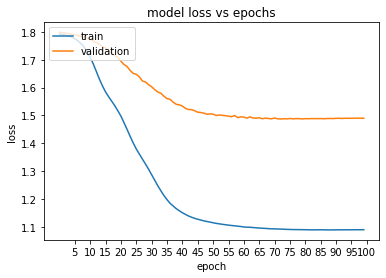

In [48]:
# Evaluate GAT Model (CiteSeer)

plt.figure(1)
plt.plot(train_loss_arr)
plt.plot(val_loss_arr)
plt.title('model loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.legend(['train', 'validation'], loc='upper left')

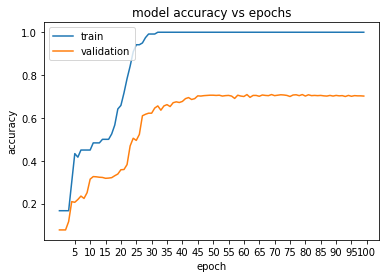

In [49]:
plt.figure(1)
plt.plot(train_acc_arr)
plt.plot(val_acc_arr)
plt.title('model accuracy vs epochs')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.legend(['train', 'validation'], loc='upper left')

In [50]:
print("test_loss: {:.4f} test_acc: {:.4f}".format(loss.item(), acc))

test_loss: 1.4901 test_acc: 0.7020


In [51]:
# add test loss and accuracy values to table

citeseer_df['Test Loss'][2] = loss.item()
citeseer_df['Test Accuracy'][2] = acc

/var/folders/1f/gg6wtk9n3yj9dh3mbt8dfd000000gn/T/ipykernel_5949/3689067437.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citeseer_df['Test Loss'][2] = loss.item()
/var/folders/1f/gg6wtk9n3yj9dh3mbt8dfd000000gn/T/ipykernel_5949/3689067437.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citeseer_df['Test Accuracy'][2] = acc


In [52]:
print(citeseer_df)

       Model  Test Loss  Test Accuracy
0        GCN   1.007584          0.686
1  GraphSAGE   1.492149          0.695
2        GAT   1.490107          0.702


In [53]:
print(cora_df)

       Model  Test Loss  Test Accuracy
0        GCN   0.772594          0.775
1  GraphSAGE   1.499864          0.795
2        GAT   1.508257          0.791
